In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os
from astropy.utils.data import get_pkg_data_filename
from astropy.timeseries import TimeSeries
from astropy.table import Table
import scipy
import random
import zipfile
from scipy import interpolate
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import pylab

# Helper Functions

In [2]:
def return_folder_paths(file_name):
    """
    @returns paths to raw and caliberated folders of that particular day file
    You need to work in the same location as the day files
    """
    raw_files_path = f'./{file_name}/xsm/data/{file_name[8:12]}/{file_name[12:14]}/{file_name[14:16]}/raw'
    calibrated_files_path = f'./{file_name}/xsm/data/{file_name[8:12]}/{file_name[12:14]}/{file_name[14:16]}/calibrated'
    return raw_files_path, calibrated_files_path

In [3]:
def lightcurve(file, should_plot=False):
    """
    Reading .lc file directly and plotting if said so
    """
    t = Table.read(file)
    tmp = t["RATE"]
    if should_plot:
        print(len(tmp))
        plt.figure(figsize=(25, 7))
        plt.grid()
        plt.scatter(range(len(tmp)), tmp, s=1)
    return tmp, t

In [4]:
def random_lc(should_plot=False, fixed_seed=False, seed=0):
    files = os.listdir()
    valid_dirs = []
    for file in files:
        if file[:3] == 'ch2':
            valid_dirs.append(file)
    if fixed_seed:
        random.seed(seed)
    file = random.choice(valid_dirs)
    raw, calib = return_folder_paths(file)
    path_to_lc = calib + '/' + file + '_level2.lc'
    lc_example, t = lightcurve(path_to_lc, should_plot=should_plot)
    return file, lc_example

In [5]:
def plotly_plot(lc):
    px.line(pd.DataFrame(lc))

# Smoothening Functions

In [6]:
def smoothen_fft(lc, thresh=200, should_plot=False):
    lc_fft = np.fft.fft(lc)
    lc_fft[thresh:len(lc)-thresh]=0
    lc_smooth = np.abs(np.fft.ifft(lc_fft))
    if should_plot:
        px.line(pd.Dataframe(lc_smooth))
    return lc_smooth

In [7]:
def smoothen_moving_mean(lc, window_sz=40, shift=20, should_plot=False, s=0.3):    
    new_norm = np.ones(len(lc))
    num_frames = 0
    # first frame
    num_frames += 1
    tmp = np.mean(lc[0:window_sz])
    new_norm[0:window_sz] *= tmp
    # rest frames
    for i in range(window_sz, len(lc), shift):
        num_frames += 1
        tmp = np.mean(lc[i:i+window_sz])
        new_norm[i:i+window_sz] = 1
        new_norm[i:i+window_sz] *= tmp
    if should_plot:
        plt.figure(figsize=(25, 7))
        plt.grid()
        plt.scatter(range(len(new_norm)), new_norm, s=s)
    # print(num_frames)
    return new_norm

In [8]:
def smoothen_moving_median(lc, window_size=4, shift=1, should_plot=False, s=0.4):
    new_norm = np.ones(len(lc))
    num_frames=0
    # first frame
    num_frames+=1
    tmp=np.median(lc[0:window_size])
    new_norm[0:window_size]*=tmp
    # rest frames
    for i in range(window_size, len(lc), shift):
        num_frames+=1
        tmp=np.median(lc[i:i+window_size])
        new_norm[i:i+window_size] = 1
        new_norm[i:i+window_size] *= tmp
    if should_plot:
        plt.figure(figsize=(25, 7))
        plt.grid()
        plt.scatter(range(len(new_norm)), new_norm, s=s)
    return new_norm

In [9]:
def compress_time_stamps(lc_example, window_size=60, should_plot=False, s=2):
    """
    Helper function for moving window smoothening functions
    """
    new_lc = np.ones(int(len(lc_example)/window_size)+1)
    for i in range(0, len(lc_example), window_size):
        new_lc[int(i/window_size)] *= lc_example[i]
    if should_plot:
        plt.figure(figsize=(25, 7))
        plt.grid()
        plt.scatter(range(len(new_lc)), new_lc, s=s)
    return new_lc

# Start Time Picking Functions

In [10]:
def start_end_std_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[0:lag - 1] += np.mean(y[0:lag])
    stdFilter[0:lag - 1] += np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

In [11]:
def start_end_std_algo_helper(lc, lag, threshold, influence):
    result = start_end_std_algo(lc, lag=lag, threshold=threshold, influence=influence)
    plt.figure(figsize=(25, 12))
    pylab.subplot(211)
    pylab.plot(np.arange(1, len(lc)+1), lc)

    pylab.plot(np.arange(1, len(lc)+1),
            result["avgFilter"], color="cyan", lw=2)

    pylab.plot(np.arange(1, len(lc)+1),
            result["avgFilter"] + threshold * result["stdFilter"], color="green", lw=2)

    pylab.plot(np.arange(1, len(lc)+1),
            result["avgFilter"] - threshold * result["stdFilter"], color="green", lw=2)

    pylab.subplot(212)
    pylab.step(np.arange(1, len(lc)+1), result["signals"], color="red", lw=2)
    # pylab.ylim(-1.5, 1.5)
    pylab.show()

In [12]:
def start_thresh_algo(lc, window_size=4, slope_threshold=20, num_frames_threshold=4):
    """
    Detects the start time of flares
    """
    counter = 0
    flare_start_time = []
    allowed_discrepancies = 0.2
    for i in range(0, len(lc)):
        if (i+window_size >= len(lc)):
            index = len(lc)-1
        else:
            index = i+window_size
        slope = (lc[index] - lc[i])/window_size
        if slope >= slope_threshold:
            counter += 1
            discrepancies = 0
            for j in range(i+1, i+window_size):
                if(j >= len(lc)):
                    continue
                # I'm assuming that moving average did the smoothing, i.e. now every flare rise will only have a rise, with a bit discrepancy
                if lc[j] < lc[j-1]:
                    discrepancies += 1
            if discrepancies<allowed_discrepancies*window_size and counter>=num_frames_threshold:
            # if counter>=num_frames_threshold:
                flare_start_time.append(i)
                i += window_size*num_frames_threshold
                counter = 0
    return np.array(flare_start_time)

In [13]:
def start_thresh_better_algo(lc, window_size=4, slope_threshold=20, num_frames_threshold=4):
    """
    Detects the start time of flares
    """
    counter = 0
    flare_start_time = []
    allowed_discrepancies = 0.2
    for i in range(0, len(lc)):
        if (i+window_size >= len(lc)):
            index = len(lc)-1
        else:
            index = i+window_size
        slope = (lc[index] - lc[i])/window_size
        if slope >= slope_threshold:
            counter += 1
            discrepancies = 0
            for j in range(i+1, i+window_size):
                if(j >= len(lc)):
                    continue
                if lc[j] < lc[j-1]:
                    discrepancies += 1
            if discrepancies<allowed_discrepancies*window_size and counter>=num_frames_threshold:
                flare_start_time.append(i)
                i += window_size*num_frames_threshold
                counter = 0
    return np.array(flare_start_time)

In [14]:
def start_thresh_algo_helper(lc, startTimes):
    for i, n in enumerate(startTimes):
        if i+1 >= len(startTimes):
            index = len(startTimes)-1
        else:
            index = i+1
        if startTimes[index] < startTimes[i]+9:
            startTimes[index] = startTimes[i]
    plt.figure(figsize=(25, 8))
    print(len(startTimes))
    plt.plot(range(len(lc)), lc)
    onesAtStartTime = np.zeros(len(lc))
    onesAtStartTime[startTimes] = 500

    plt.plot(range(len(lc)), onesAtStartTime, 'y')
    # plotly_plot(lc)
    return onesAtStartTime

36695


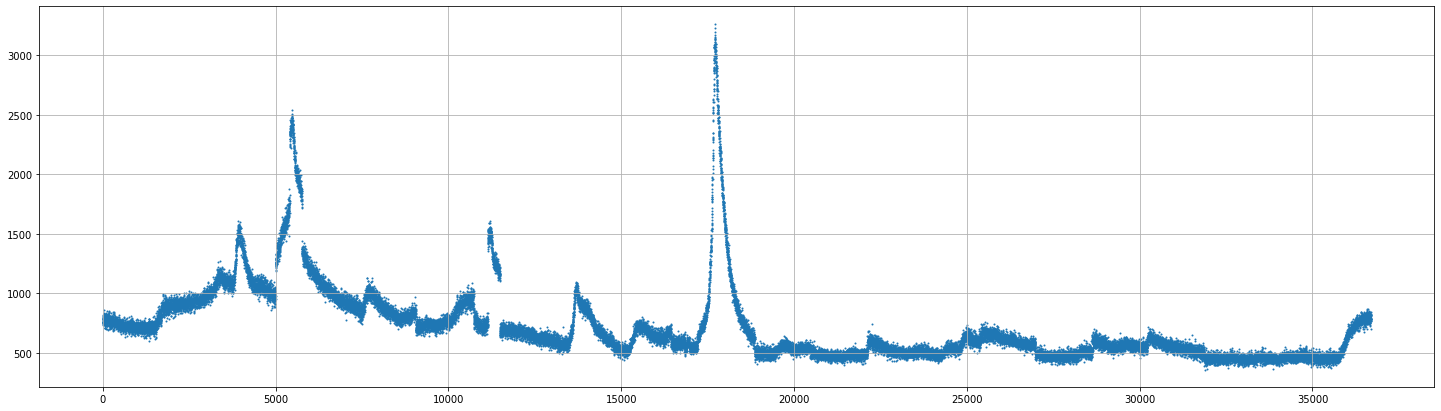

In [26]:
file, lc = random_lc(should_plot=True)

In [42]:
window_median = 40
shift = 20
lc_smooth_median = smoothen_moving_median(lc, should_plot=False, window_size=window_median, shift=30)
lc_smooth_compressed = compress_time_stamps(lc_example=lc_smooth_median, window_size=window_median, should_plot=False)
w=3
slope_threshold=35
num_frames_threshold=2
# startTimes = start_thresh_algo(lc, window_size=20, slope_threshold=slope_threshold, num_frames_threshold=num_frames_threshold)
startTimes = start_thresh_algo(lc_smooth_compressed, w, slope_threshold=slope_threshold, num_frames_threshold=num_frames_threshold)
# print(startTimes)
for i, startTime in enumerate(startTimes):
    j = 0
    while i+j < len(startTimes) and startTimes[i+j] == startTime+2*j:
        startTimes[i+j] = startTime
        j+=1
        if j >= len(startTimes):
            j-=1

startTimes = np.sort(list(set(startTimes)))
print(len(startTimes))
print(startTimes)

11
[ 93 123 131 187 276 337 381 429 434 551 897]


11


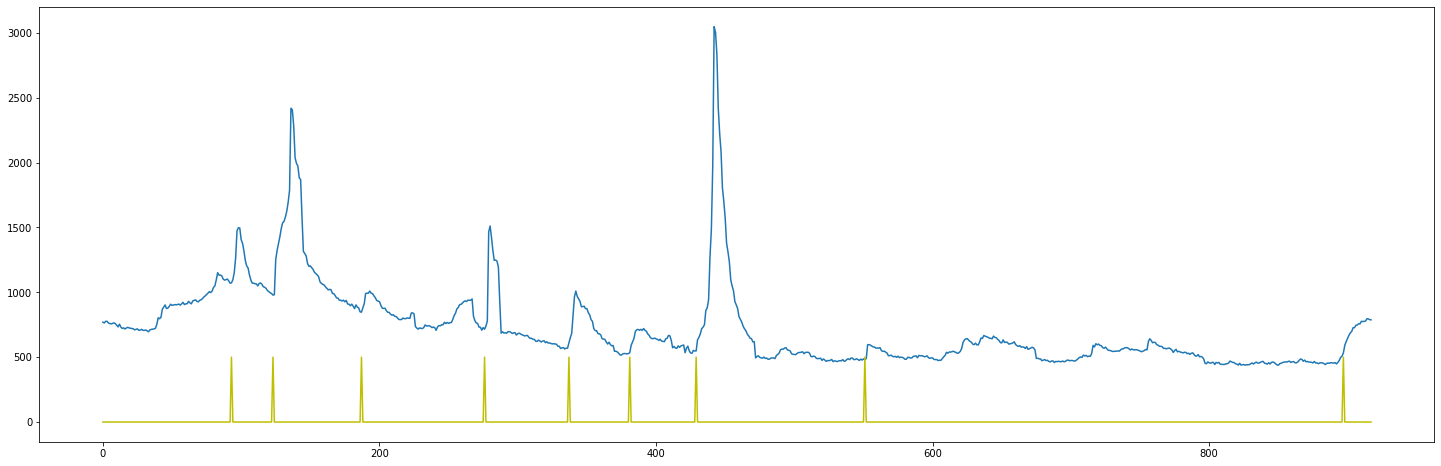

In [43]:
onesAtStartTime = start_thresh_algo_helper(lc_smooth_compressed, startTimes=startTimes)

11
[108, 124, 168, 206, 288, 365, 425, 430, 472, 604, 917]


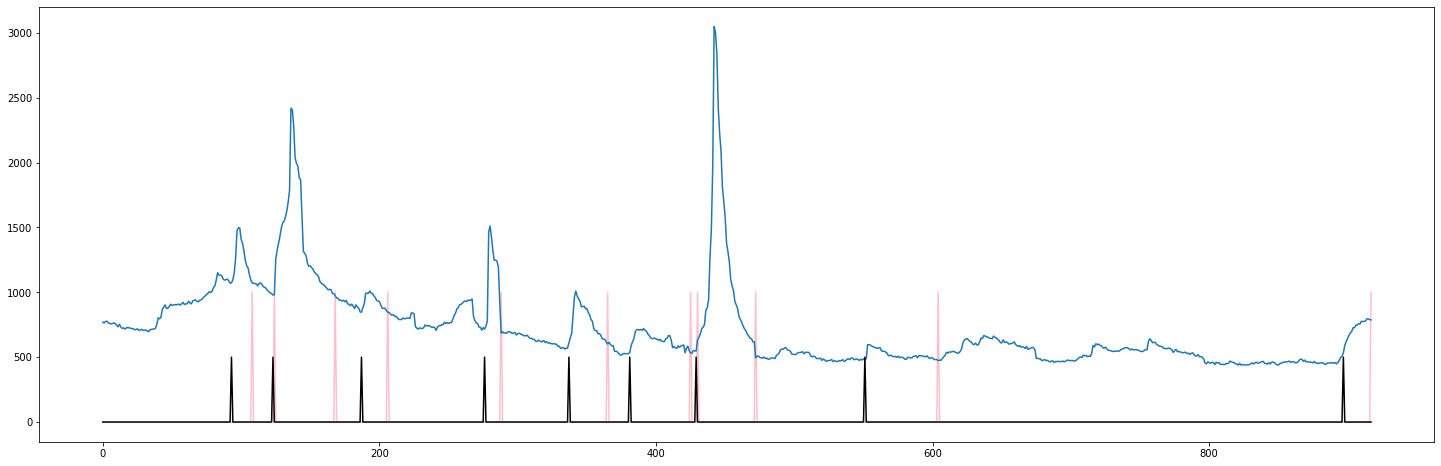

In [44]:
def end_thresh_algo(lc_compressed, startTimes):
    endTimes = []
    for i, startTime in enumerate(startTimes):
        y_val = lc_compressed[startTime]
        # print("Y val at start: ", y_val)
        counter = startTime+1
        tmp = startTimes[i+1] if i+1<len(startTimes) else len(lc_compressed)
        peakReached = False
        while counter < len(lc_compressed)-1 and lc_compressed[counter] > y_val and counter < tmp:
            # print("Increased to: ", lc_compressed[counter])
            # print("At counter: ", counter)
            if counter > len(lc_compressed):
                counter = len(lc_compressed) - 1
            # print(counter)
            counter += 1
        # print("Appended counter: ", counter)
        endTimes.append(counter)
    return endTimes

endTimes = end_thresh_algo(lc_smooth_compressed, startTimes=startTimes)
print(len(endTimes))
print(endTimes)
onesAtEndTimes = np.zeros(len(lc_smooth_compressed))
onesAtEndTimes[endTimes] = 1000
plt.figure(figsize=(25,8))
plt.plot(onesAtEndTimes, 'pink')
plt.plot(lc_smooth_compressed)
plt.plot(onesAtStartTime, 'black')

In [45]:
startTimes

array([ 93, 123, 123, 187, 276, 337, 381, 429, 429, 551, 897])

In [46]:
endTimes = np.array(endTimes)
endTimes

array([108, 124, 168, 206, 288, 365, 425, 430, 472, 604, 917])

In [62]:
def cleanedDataFrame(startTimes, endTimes, window_median):
    df = pd.DataFrame(zip(startTimes, endTimes))
    df.columns = ["Start Time", "End Time"]
    df["Start Time"] *= window_median
    df["End Time"] *= window_median
    drops = []
    for i, startTime in enumerate(np.array(df["Start Time"])):
        if i+1 < len(df["Start Time"]):
            if df["Start Time"].iloc[i+1] == startTime:
                drops.append(i)
    print(drops)
    df.drop(drops, axis=0, inplace=True)
    # df.drop(drops, axis=0)
    df.reset_index(drop=True, inplace=True)
    return df
df = cleanedDataFrame(startTimes=startTimes, endTimes=endTimes, window_median=window_median)

[1, 7]


In [63]:
df.to_csv('start_end_times.csv')
np.savetxt('lc.csv', lc_smooth_compressed, delimiter=',')

84991


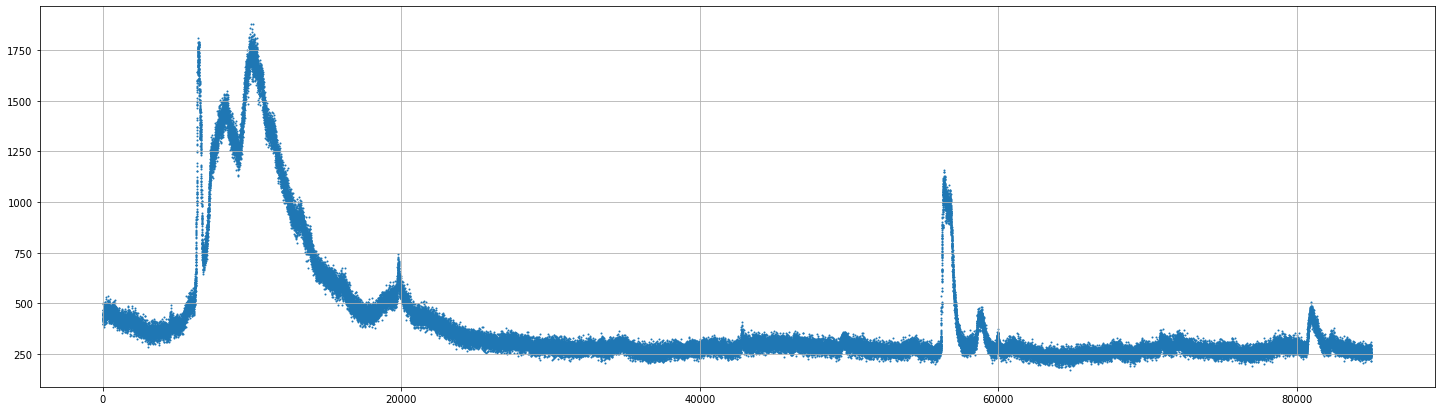

In [21]:
file2, lc2 = lightcurve('ch2_xsm_20211012_v1/xsm/data/2021/10/12/calibrated/ch2_xsm_20211012_v1_level2.lc', should_plot=True)